# Alt Kelimeler (sub-word) Nedir ?

Bu ortak çalışmada, alt sözcüklerle veya daha büyük sözcüklerin parçalarından oluşan sözcüklerle çalışacağız ve bunun ağımızı ve ilgili yerleştirmeleri nasıl etkilediğini göreceğiz.

## TensorFlow Kütüphanesinin ve Gerekli İşlevlerin İçeri Aktarılması 

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

## Veri Setinin Alınması

Amazon ve Yelp incelemelerini (yorumlarını) içeren veri setini bir kez daha kullanacağız. Bu veri seti orijinal olarak [buradan](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set) alınmıştır.


In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2021-07-28 11:38:00--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 108.177.97.100, 108.177.97.101, 108.177.97.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.97.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/coa4uu4h64moik3anj2ik7a4p1ju6fik/1627472250000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2021-07-28 11:38:00--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/coa4uu4h64moik3anj2ik7a4p1ju6fik/1627472250000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|64.233

In [3]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Önce cümleleri ve etiketleri çıkarmanız yeterlidir - burada alt kelimeler oluşturacağız
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

## Alt Kelime Veri Setinin Oluşturulması

Mevcut Amazon ve Yelp inceleme (yorum) veri setini `tensorflow_datasets` içerisinde bulunan `SubwordTextEncode` işlevi ile yapacağız. `SubwordTextEncoder.build_from_corpus()` bizim için bir tokenize edici oluşturur. Bu işlevi aynı zamanda çok daha büyük bir metin bütününden alt sözcükler almak için de kullanabilirsiniz, ancak biz burada sadece mevcut veri setimizi kullanacağız.

Kullandığımız Amazon ve Yelp veri seti çok büyük değil, bu yüzden sadece en yaygın 1.000 kelimeden oluşan bir alt kelimesi seti oluşturacağız ve her bir alt kelimeyi en fazla 5 karakter olacak şekilde keseceğiz.

İlgili belgelere [buradan](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus) göz atabilirsiniz.

In [4]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [5]:
# Tokenize edicinin doğru çalıştığını kontrol edin
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Her bir alt sözcüğü ayrı ayrı yazdırın, kodu çözerek
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Cümle Verilerinin Kodlanmış Al Sözcükler İle Değiştirilmesi

Şimdi, her bir cümleyi fiilen kodlayarak eğitim için kullanılacak veri setini yeniden oluşturacağız. Bu daha önceki modelde kullanılan `text_to_sequences` ve  `Tokenizer`'e eş değerdir.

In [6]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [7]:
# Cümlelerin uygun şekilde değiştirildiğini kontrol edin
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


## Son Ön İşlemenin Yapılması

Eğitimden önce, dizileri doldurmanın yanı sıra eğitim ve test setlerine ayırmamız gerekiyor.


In [9]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Tüm cümleleri doldurun (padding)
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Cümleleri ve etiketleri, eğitim ve test setlerine ayırın
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Etiketleri daha sonra ağda kullanmak üzere numpy dizilerine dönüştürün
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Duygu Analizi Modelinin Eğitilmesi

In [10]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 4s 10ms/step - loss: 0.6919 - accuracy: 0.5235 - val_loss: 0.6965 - val_accuracy: 0.4185
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5342 - val_loss: 0.6980 - val_accuracy: 0.4336
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5719 - val_loss: 0.6924 - val_accuracy: 0.4962
Epoch 4/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.5995 - val_loss: 0.6863 - val_accuracy: 0.5138
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6629 - accuracy: 0.6365 - val_loss: 0.6779 - val_accuracy: 0.5363
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6419 - accuracy: 0.6962 - val_loss: 0.6651 - val_accuracy: 0.5464
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6121 - accuracy: 0.7502 - val_loss: 0.6407 - val_accuracy: 0.6341
Epoch 8/30
50/50 [=

## Eğitim Sürecinin Grafik İle Görselleştirilmesi

Hiperparametrelerde ve modelde farklı ince ayarlar denerken eğitim ve doğrulama seti doğruluğunu (`accuracy`) görselleştirmek için aşağıdaki kodu kullanabilirsiniz.

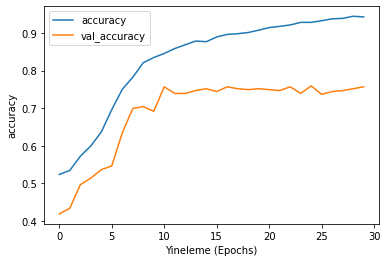

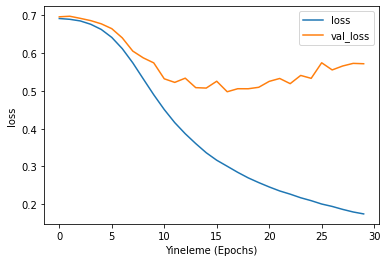

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Yineleme (Epochs)")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Ağı Görselleştirmek İçin Dosyaların Alınması

Aşağıdaki kod, ağınızın her bir kelimeyle ilgili duyguyu nasıl "gördüğünü" görselleştirmek için iki dosya indirecektir. http://projector.tensorflow.org/ adresine gidin ve bu dosyaları yükleyin, ardından verileri "küreleştirmek" için onay kutusunu tıklamayı unutmayın.

Aşağıdaki kodun, yerleşik `Tokenizer` ile öncekine kıyasla, veri kümemizde metnin farklı şekilde kodlanmasını işlemek için birkaç küçük değişiklik olduğunu unutmayın.

"Tensor sayısı (999), meta verilerdeki satır sayısıyla (992) eşleşmiyor" (Number of tensors (999) do not match the number of lines in metadata (992)) gibi bir hata alabilirsiniz. Önce vektörleri hatasız yüklediğiniz ve bu belirdikten sonra birkaç saniye beklediğiniz sürece, dosya yükleme menüsünün dışına tıklayabilir ve yine de görselleştirmeyi görüntüleyebilirsiniz.


In [13]:
# İlk önce gömme katmanının ağırlıklarını alın
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # şekil: (vocab_size, embedding_dim)

(1000, 16)


In [14]:
import io

# Gömme vektörlerini ve meta verileri yazın
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
# Dosyaları İndirin
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>